In [48]:
import timeit
start_time = timeit.default_timer()

In [49]:
import hashlib
import time
from collections import defaultdict
import random
import json
import matplotlib
import matplotlib.pyplot as plt

In [50]:
class Transaction:
    def __init__(self, sender, recipient, amount):
        self.sender = sender
        self.recipient = recipient
        self.amount = amount
    
    def to_dict(self):
        return {
            'sender': self.sender,
            'recipient': self.recipient,
            'amount': self.amount,
        }

        
class Block:
    def __init__(self, index, previous_hash, transactions, timestamp, proof):
        self.index = index
        self.previous_hash = previous_hash
        self.transactions = transactions
        self.timestamp = timestamp
        self.proof = proof

    def calculate_hash(self):
        return hashlib.sha256(f"{self.index}{self.previous_hash}{self.transactions}{self.timestamp}{self.proof}".encode()).hexdigest()


In [51]:

class Blockchain:
    def __init__(self):
        self.chain = []
        self.current_transactions = []
        self.create_genesis_block()

    def create_genesis_block(self):
        self.create_block(proof=0, previous_hash="0")

    def create_block(self, proof, previous_hash):
        block = Block(
            index=len(self.chain) + 1,
            previous_hash=previous_hash or self.hash(self.chain[-1]),
            transactions=self.current_transactions,
            timestamp=time.time(),
            proof=proof,
        )
        self.current_transactions = []
        self.chain.append(block)
        return block

    def add_transaction(self, sender, recipient, amount):
        self.current_transactions.append(Transaction(sender, recipient, amount))

    @staticmethod
    def hash(block):
        return block.calculate_hash()

    def last_block(self):
        return self.chain[-1] if self.chain else None


In [52]:

class PoWConsensus:
    @staticmethod
    def proof_of_work(last_proof, difficulty=6):
        proof = 0
        while PoWConsensus.validate_proof(last_proof, proof, difficulty) is False:
            proof += 1
        return proof

    @staticmethod
    def validate_proof(last_proof, proof, difficulty=6):
        guess = f"{last_proof}{proof}".encode()
        guess_hash = hashlib.sha256(guess).hexdigest()
        return guess_hash[:difficulty] == "0" * difficulty


def verify_transaction(transaction):
    if 'sender' not in transaction or 'recipient' not in transaction or 'amount' not in transaction:
        return False  

    sender = transaction['sender']
    recipient = transaction['recipient']
    amount = transaction['amount']

    return True  # Return True if the transaction is valid, False otherwise

In [53]:
class PoSConsensus:
    def __init__(self):
        self.validators = []
        self.chain = []
        self.current_transactions = []
        self.create_genesis_block()

    def create_genesis_block(self):
        self.create_block(proof=0, previous_hash="0")

    def create_block(self, proof, previous_hash):
        block = Block(
            index=len(self.chain) + 1,
            previous_hash=previous_hash or self.hash(self.chain[-1]),
            transactions=self.current_transactions,
            timestamp=time.time(),
            proof=proof,
        )
        self.current_transactions = []
        self.chain.append(block)
        return block

    def add_transaction(self, sender, recipient, amount):
        self.current_transactions.append(Transaction(sender, recipient, amount))

    def add_validator(self, validator):
        self.validators.append(validator)

    def select_validator(self):
        return random.choice(self.validators)

    def proof_of_stake(self, last_block):
        validator = self.select_validator()
        proof = 0
        while self.validate_proof(last_block.proof, proof, validator) is False:
            proof += 1
        return proof

    @staticmethod
    def validate_proof(last_proof, proof, validator):
        guess = f"{last_proof}{proof}{validator}".encode()
        guess_hash = hashlib.sha256(guess).hexdigest()
        return guess_hash[:4] == "0000"

    def last_block(self):
        return self.chain[-1] if self.chain else None

    def get_previous_hash(self, last_block):
        return self.hash(last_block)

    @staticmethod
    def hash(block):
        block_string = json.dumps(block.__dict__, sort_keys=True, default=lambda x: x.to_dict())
        return hashlib.sha256(block_string.encode()).hexdigest()

In [54]:
# uPDATED
class DPoSConsensus:
    def __init__(self):
        self.delegates = []
        self.chain = []
        self.current_transactions = []
        self.votes = {}  # Dictionary to store votes
        self.create_genesis_block()

    def create_genesis_block(self):
        self.create_block(proof=0, previous_hash="0")

    def create_block(self, proof, previous_hash):
        block = Block(
            index=len(self.chain) + 1,
            previous_hash=previous_hash or self.hash(self.chain[-1]),
            transactions=self.current_transactions,
            timestamp=time.time(),
            proof=proof,
        )
        self.current_transactions = []
        self.chain.append(block)
        return block

    def add_transaction(self, sender, recipient, amount):
        self.current_transactions.append(Transaction(sender, recipient, amount))

    def add_delegate(self, delegate):
        self.delegates.append(delegate)
        self.votes[delegate] = []  # Initialize votes for the new delegate

    def select_delegate(self):
        return random.choice(self.delegates)

    def delegated_proof_of_stake(self, last_block):
        delegate = self.select_delegate()
        proof = 0
        while self.validate_proof(last_block.proof, proof, delegate) is False:
            proof += 1
        return proof

    @staticmethod
    def validate_proof(last_proof, proof, delegate):
        guess = f"{last_proof}{proof}{delegate}".encode()
        guess_hash = hashlib.sha256(guess).hexdigest()
        return guess_hash[:4] == "0000"

    def last_block(self):
        return self.chain[-1] if self.chain else None

    def get_previous_hash(self, last_block):
        return self.hash(last_block)

    @staticmethod
    def hash(block):
        block_string = json.dumps(block.__dict__, sort_keys=True, default=lambda x: x.to_dict())
        return hashlib.sha256(block_string.encode()).hexdigest()

    def vote(self, delegate, voter):
        if delegate in self.delegates and voter in self.delegates:
            self.votes[delegate].append(voter)

    def get_vote_count(self, delegate):
        return len(self.votes.get(delegate, []))


In [55]:
class RaftNode:
    def __init__(self, node_id, total_nodes):
        self.node_id = node_id
        self.total_nodes = total_nodes
        self.current_term = 0
        self.voted_for = None
        self.log = []
        self.commit_index = 0
        self.last_applied = 0
        self.state = "follower"
        self.leader_id = None
        self.timeout = random.randint(150, 300) / 1000.0  # Simulated election timeout
        self.votes_received = defaultdict(lambda: False)
        self.last_heartbeat = time.time()  # Initialize last heartbeat time

    def become_follower(self, term, leader_id):
        self.state = "follower"
        self.current_term = term
        self.voted_for = None
        self.leader_id = leader_id

    def become_candidate(self):
        self.state = "candidate"
        self.current_term += 1
        self.voted_for = self.node_id
        self.votes_received = defaultdict(lambda: False)
   

    def become_leader(self):
        self.state = "leader"
        self.leader_id = self.node_id

    def request_vote(self, term, candidate_id, last_log_index, last_log_term):
        if term < self.current_term:
            return False

        if term > self.current_term:
            self.become_follower(term, None)

        if self.voted_for is None or self.voted_for == candidate_id:
            # Check if candidate's log is at least as up-to-date as our log
            if last_log_term > self.log[-1]["term"] or (
                last_log_term == self.log[-1]["term"] and last_log_index >= len(self.log)
            ):
                self.voted_for = candidate_id
                return True

        return False

    def append_entries(self, term, leader_id, prev_log_index, prev_log_term, entries, leader_commit):
        if term < self.current_term:
            return False

        if term >= self.current_term:
            self.become_follower(term, leader_id)

        if prev_log_index >= len(self.log) or self.log[prev_log_index]["term"] != prev_log_term:
            return False

        self.log = self.log[: prev_log_index + 1] + entries
        if leader_commit > self.commit_index:
            self.commit_index = min(leader_commit, len(self.log) - 1)

        return True

    def send_heartbeat(self):
        # Simulate sending a heartbeat to followers
        pass
    # Inside RaftNode class
    def update_election_timeout(self):
        self.timeout = random.randint(150, 300) / 1000.0

    def simulate(self,max_duration_seconds):
        start_time = time.time()
        while time.time() - start_time < max_duration_seconds:
            if self.state == "follower":
                if time.time() - self.last_heartbeat > self.timeout:
                    self.update_election_timeout()  # Update election timeout
                    self.become_candidate()
            elif self.state == "candidate":
                if time.time() - self.last_heartbeat > self.timeout:
                    self.update_election_timeout()  # Update election timeout
                    self.become_candidate()

                    # Request votes from other nodes
                    votes = 1  # Vote for self
                    for node_id in range(self.total_nodes):
                        if node_id != self.node_id:
                            if self.log and self.request_vote(self.current_term, node_id, len(self.log) - 1, self.log[-1]["term"]):
                                votes += 1
                                if votes > self.total_nodes / 2:
                                    self.become_leader()
                                    break
            elif self.state == "leader":
                if time.time() - self.last_heartbeat > 0.1:
                    self.send_heartbeats()  # Send heartbeats to followers
                    self.last_heartbeat = time.time()  # Update last heartbeat time
                    self.update_commit_index()  # Update commit index
            time.sleep(0.1)  # Sleep to avoid busy-waiting

  
    def process_transaction(self):
        # Simulate transaction processing
        self.transaction_processing_time = random.uniform(0.001, 0.005)  # Simulated transaction processing time
        time.sleep(self.transaction_processing_time)
            
def find_initial_leader(nodes):
    # Find an initial leader node
    for node in nodes:
        if node.state == "leader":
            return node
    return None

In [56]:
def simulate_pow_throughputs():
    blockchain_pow = Blockchain()
    num_transactions_pow = [100, 500, 1000, 1500, 2000]
    throughputs_pow = {}

    for num_tx in num_transactions_pow:
        start_time = time.time()
        for _ in range(num_tx):
            sender = "Arafat"
            recipient = "Chopra"
            amount = 1

            # Verify the transaction before adding it to the blockchain
            if verify_transaction({"sender": sender, "recipient": recipient, "amount": amount}):
                blockchain_pow.add_transaction(sender, recipient, amount)
            else:
                print("Invalid transaction:", {"sender": sender, "recipient": recipient, "amount": amount})

        last_block_pow = blockchain_pow.last_block()
        last_proof_pow = last_block_pow.proof
        
        # Adjust the difficulty level as needed (e.g., difficulty=4)
        proof_pow = PoWConsensus.proof_of_work(last_proof_pow, difficulty=6)
        
        blockchain_pow.add_transaction(sender="0", recipient="MinerAddress", amount=1)
        previous_hash_pow = blockchain_pow.hash(last_block_pow)
        blockchain_pow.create_block(proof_pow, previous_hash_pow)
        end_time = time.time()
        if end_time != start_time:
            throughput_pow = num_tx / (end_time - start_time)
            throughputs_pow[num_tx] = throughput_pow
        else:
            print("Zero time difference, throughput not calculated for", num_tx, "transactions")

        print(throughputs_pow)
    visualize_pow_throughput(throughputs_pow)


In [57]:
def simulate_pos_throughputs():
    blockchain_pos = PoSConsensus()
    validator_addresses = ["Validator_1", "Validator_2", "Validator_3", "Validator_4", "Validator_4", "Validator_5"]
    for address in validator_addresses:
        blockchain_pos.add_validator(address)

    
    # Simulation for PoS
    num_transactions_pos = [100, 200,300, 400, 500, 600, 700, 800, 900, 1000]
    throughputs_pos = {}
    pos_latencies = {}


    for num_tx in num_transactions_pos:
        start_time = time.time()
        for _ in range(num_tx):
            blockchain_pos.add_transaction("Arafat", "Chopra", 5)
        last_block_pos = blockchain_pos.last_block()
        proof_pos = blockchain_pos.proof_of_stake(last_block_pos)
        blockchain_pos.add_transaction(sender="00", recipient="MinerAddress", amount=5)
        
        previous_hash_pos = blockchain_pos.get_previous_hash(last_block_pos)
        blockchain_pos.create_block(proof_pos, previous_hash_pos)
        end_time = time.time()
        pos_latencies[num_tx] = (end_time - start_time) / num_tx
        
        # Calculate throughput
        time_taken = end_time - start_time
        throughput_pos = num_tx / time_taken
        throughputs_pos[num_tx] = throughput_pos

        # Calculate and store latency
        pos_latencies[num_tx] = time_taken / num_tx
        #print(throughputs_pos)

    visualize_pos_throughput(throughputs_pos)


In [58]:
def simulate_dpos_throughputs():
    blockchain_dpos = DPoSConsensus()
    delegate_addresses = ["Delegate1", "Delegate2", "Delegate3"]  
    for address in delegate_addresses:
        blockchain_dpos.add_delegate(address)

    num_transactions_dpos = [100, 500, 1000, 1500, 2000]
    throughputs_dpos = {}

    for num_tx in num_transactions_dpos:
        start_time = time.time()
        for _ in range(num_tx):
            blockchain_dpos.add_transaction("Arafat", "Chopra", 1)
        last_block_dpos = blockchain_dpos.last_block()
        proof_dpos = blockchain_dpos.delegated_proof_of_stake(last_block_dpos)
        blockchain_dpos.add_transaction(sender="0", recipient="MinerAddress", amount=1)
        previous_hash_dpos = blockchain_dpos.get_previous_hash(last_block_dpos)
        blockchain_dpos.create_block(proof_dpos, previous_hash_dpos)
        end_time = time.time()
        
        time_taken = end_time - start_time
        throughput_dpos = num_tx / time_taken
        throughputs_dpos[num_tx] = throughput_dpos
        print(throughputs_dpos)
    visualize_dpos_throughput(throughputs_dpos)


In [59]:
def simulate_raft_throughputs():
    num_nodes = 5
    num_transactions_list = [100, 500, 1000, 1500, 2000]  # Reduced number of transactions
    initial_leader_node_id = 0  # Manually specify the initial leader node ID
    max_duration_seconds = 5  # Specify the maximum duration of the simulation in seconds
    
    nodes = [RaftNode(node_id, num_nodes) for node_id in range(num_nodes)]

    throughputs = {}

    for num_tx in num_transactions_list:
        start_time = time.time()
        print(f"Starting transaction loop for {num_tx} transactions...")

        # Reset all nodes to "follower" state
        for node in nodes:
            node.state = "follower"
        
        # Find the initial leader node
        initial_leader = nodes[initial_leader_node_id]
        initial_leader.become_leader()

        # Track how many transactions have been processed by all nodes
        transactions_processed = 0

        while transactions_processed < num_tx:
            leader_node = find_initial_leader(nodes)

            if leader_node is not None:
                leader_node.process_transaction()
                transactions_processed += 1

        end_time = time.time()
        print(f"Transaction loop for {num_tx} transactions completed in {end_time - start_time:.2f} seconds.")

        time_taken = end_time - start_time
        if time_taken > 0:
            throughput = num_tx / time_taken
            throughputs[num_tx] = throughput

    visualize_raft_throughput(throughputs)


In [60]:
def simulate_latency_impact():
    num_transactions = [100, 500, 1000, 1500, 2000]
    num_nodes = 5  
    max_duration_seconds = 5  # Set this to the desired duration for your Raft simulation (e.g., 60 seconds)
    pow_latencies = {}
    pos_latencies = {}
    dpos_latencies = {}
    raft_latencies = {}

    for num_tx in num_transactions:
        # PoW simulation
        blockchain_pow = Blockchain()
        start_time = time.time()
        for _ in range(num_tx):
            blockchain_pow.add_transaction("Aarafat", "Chopra", 1)
        last_block_pow = blockchain_pow.last_block()
        last_proof_pow = last_block_pow.proof
        proof_pow = PoWConsensus.proof_of_work(last_proof_pow)
        blockchain_pow.add_transaction(sender="0", recipient="MinerAddress", amount=1)
        previous_hash_pow = blockchain_pow.hash(last_block_pow)
        blockchain_pow.create_block(proof_pow, previous_hash_pow)
        end_time = time.time()
        pow_latencies[num_tx] = (end_time - start_time) / num_tx

        # PoS simulation
        blockchain_pos = PoSConsensus()
        validator_addresses = ["Validator1", "Validator2", "Validator3"] 
        for address in validator_addresses:
            blockchain_pos.add_validator(address)

        start_time = time.time()
        for _ in range(num_tx):
            blockchain_pos.add_transaction("Aarafat", "Chopra", 1)
        last_block_pos = blockchain_pos.last_block()
        proof_pos = blockchain_pos.proof_of_stake(last_block_pos)
        blockchain_pos.add_transaction(sender="0", recipient="MinerAddress", amount=1)
        previous_hash_pos = blockchain_pos.get_previous_hash(last_block_pos)
        blockchain_pos.create_block(proof_pos, previous_hash_pos)
        end_time = time.time()
        pos_latencies[num_tx] = (end_time - start_time) / num_tx
        
        
        # DPoS simulation
        blockchain_dpos = DPoSConsensus()
        delegate_addresses = ["Delegate1", "Delegate2", "Delegate3"]
        for address in delegate_addresses:
            blockchain_dpos.add_delegate(address)

        start_time = time.time()
        for _ in range(num_tx):
            blockchain_dpos.add_transaction("Aarafat", "Chopra", 1)
        last_block_dpos = blockchain_dpos.last_block()
        proof_dpos = blockchain_dpos.delegated_proof_of_stake(last_block_dpos)
        blockchain_dpos.add_transaction(sender="0", recipient="MinerAddress", amount=1)
        previous_hash_dpos = blockchain_dpos.get_previous_hash(last_block_dpos)
        blockchain_dpos.create_block(proof_dpos, previous_hash_dpos)
        end_time = time.time()
        dpos_latencies[num_tx] = (end_time - start_time) / num_tx
        

    

        # raft
        nodes = [RaftNode(node_id, num_nodes) for node_id in range(num_nodes)]
        start_time = time.time()

        # Simulate Raft behavior
        for node in nodes:
            node.simulate(max_duration_seconds)

        end_time = time.time()

        # Calculate average latency per transaction
        latency = (end_time - start_time) / num_tx
        raft_latencies[num_tx] = latency

    

        
    # Visualize the impact of different numbers of transactions on latency for PoW and PoS
    print("pow_latencies:",pow_latencies)
    print("pos_latencies:",pos_latencies)
    print("dpos_latencies:",dpos_latencies)
    print("raft_latencies:",raft_latencies)
    visualize_PoW_latency_impact(pow_latencies)
    visualize_PoS_latency_impact(pos_latencies)
    visualize_dpos_latency_impact(dpos_latencies)
    visualize_raft_latency_impact(raft_latencies)
    
    visualize_latency_comparison(pow_latencies, pos_latencies,dpos_latencies,raft_latencies)


In [61]:
'''
Simulate latency for different transection.
using a fixed number of transactions (1000 in this) to calculate the latency for each case.
'''

def simulate_latency_with_nodes_pow(num_nodes):
    # Simulate PoW latency with varying numbers of nodes
    latencies = {}
    for num_n in num_nodes:
        blockchain_nodes = Blockchain()
        start_time = time.time()
        for _ in range(1000):  # Simulate with a fixed number of transactions
            blockchain_nodes.add_transaction("Arafat", "Chopra", 1)
        last_block_nodes = blockchain_nodes.last_block()
        last_proof_nodes = last_block_nodes.proof
        proof_nodes = PoWConsensus.proof_of_work(last_proof_nodes)
        blockchain_nodes.add_transaction(sender="0", recipient="MinerAddress", amount=1)
        previous_hash_nodes = blockchain_nodes.hash(last_block_nodes)
        blockchain_nodes.create_block(proof_nodes, previous_hash_nodes)
        end_time = time.time()
        latencies[num_n] = (end_time - start_time) / 1000  # Average latency over 1000 transactions
    return latencies

def simulate_latency_with_nodes_pos(num_nodes):
    # Simulate PoS latency with varying numbers of nodes
    latencies = {}
    for num_n in num_nodes:
        blockchain_nodes = PoSConsensus()
        validator_addresses = ["Validator1", "Validator2", "Validator3"]
        for address in validator_addresses:
            blockchain_nodes.add_validator(address)
        start_time = time.time()
        for _ in range(1000):  # Simulate with a fixed number of transactions
            blockchain_nodes.add_transaction("Arafat", "Chopra", 1)
        last_block_nodes = blockchain_nodes.last_block()
        proof_nodes = blockchain_nodes.proof_of_stake(last_block_nodes)
        blockchain_nodes.add_transaction(sender="0", recipient="MinerAddress", amount=1)
        previous_hash_nodes = blockchain_nodes.get_previous_hash(last_block_nodes)
        blockchain_nodes.create_block(proof_nodes, previous_hash_nodes)
        end_time = time.time()
        latencies[num_n] = (end_time - start_time) / 1000  # Average latency over 1000 transactions
    return latencies


def simulate_latency_with_nodes_dpos(num_nodes):
    # Simulate DPoS latency with varying numbers of nodes
    latencies = {}
    for num_n in num_nodes:
        blockchain_nodes = DPoSConsensus()
        delegate_addresses = ["Delegate1", "Delegate2", "Delegate3"]
        for address in delegate_addresses:
            blockchain_nodes.add_delegate(address)
        start_time = time.time()
        for _ in range(1000):  # Simulate with a fixed number of transactions
            blockchain_nodes.add_transaction("Arafat", "Chopra", 1)
        last_block_nodes = blockchain_nodes.last_block()
        proof_nodes = blockchain_nodes.delegated_proof_of_stake(last_block_nodes)
        blockchain_nodes.add_transaction(sender="0", recipient="MinerAddress", amount=1)
        previous_hash_nodes = blockchain_nodes.get_previous_hash(last_block_nodes)
        blockchain_nodes.create_block(proof_nodes, previous_hash_nodes)
        end_time = time.time()
        latencies[num_n] = (end_time - start_time) / 1000  # Average latency over 1000 transactions
    return latencies

def simulate_latency_with_nodes_raft(num_nodes):
    # Simulate Raft latency with varying numbers of nodes
    latencies = {}
    for num_n in num_nodes:
        nodes = [RaftNode(node_id, num_n) for node_id in range(num_n)]
        start_time = time.time()

        print(f"Simulating Raft with {num_n} nodes...")

        # Simulate Raft behavior
        for node in nodes:
            node.simulate(max_duration_seconds=5)

        end_time = time.time()
        elapsed_time = end_time - start_time
        latencies[num_n] = elapsed_time / 1000  # Average latency over 1000 transactions
        
        print(f"Simulation with {num_n} nodes completed in {elapsed_time:.2f} seconds.")
    return latencies



In [62]:
# Visualization functions for PoW and PoS

def visualize_pow_throughput(throughputs):
    plt.plot(throughputs.keys(), throughputs.values(), marker='o')
    plt.xlabel('Number of Transactions')
    plt.ylabel('Average Throughput (Transactions per Second)')
    plt.title('Average Throughput with Varying Numbers of Transactions (Proof of Work)')
    plt.grid(True)
    plt.show()

def visualize_pos_throughput(throughputs):
    plt.plot(throughputs.keys(), throughputs.values(), marker='o')
    plt.xlabel('Number of Transactions')
    plt.ylabel('Average Throughput (Transactions per Second)')
    plt.title('Average Throughput with Varying Numbers of Transactions (Proof of Stake)')
    plt.grid(True)
    plt.savefig('Average Throughput with Varying Numbers of Transactions (Proof of Stake).png', dpi=300, bbox_inches='tight')
    plt.show()
    
def visualize_dpos_throughput(throughputs_dpos):
    plt.plot(throughputs_dpos.keys(), throughputs_dpos.values(), marker='o')
    plt.xlabel('Number of Transactions')
    plt.ylabel('Average Throughput (Transactions per Second)')
    plt.title('Average Throughput with Varying Numbers of Transactions (DPoS)')
    plt.grid(True)
    plt.show()

def visualize_raft_throughput(throughputs):
    plt.plot(throughputs.keys(), throughputs.values(), marker='o')
    plt.xlabel('Number of Transactions')
    plt.ylabel('Average Throughput (Transactions per Second)')
    plt.title('Average Throughput with Varying Numbers of Transactions (Raft)')
    plt.grid(True)
    plt.show()

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_pos_throughput(throughputs):
    # Set a seaborn style
    sns.set(style="darkgrid")

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 5))

    # Plot the data as a line plot
    sns.lineplot(x=list(throughputs.keys()), y=list(throughputs.values()), marker='o', ax=ax, markersize=8, color='skyblue')

    # Add labels and title
    ax.set_xlabel('Number of Transactions', fontsize=14)
    ax.set_ylabel('Average Throughput (Transactions per Second)', fontsize=14)
    ax.set_title('Average Throughput with Varying Numbers of Transactions (Proof of Stake)', fontsize=16)

    # Add grid lines
    ax.grid(True)

    # Customize the plot aesthetics
    sns.despine(trim=True, left=True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Save the figure and show
    plt.tight_layout()
    plt.savefig('Average_Throughput_Pos.png', dpi=300)
    plt.show()

# Example usage:
# visualize_pos_throughput(your_throughput_data)


In [64]:
def visualize_PoW_latency_impact(latencies):
    plt.plot(latencies.keys(), latencies.values(), marker='o')
    plt.xlabel('Number of Transactions')
    plt.ylabel('Average Latency (Seconds)')
    plt.title('Impact of Different Numbers of Transactions on Latency (PoW)')
    plt.grid(True)
    plt.show()
    
def visualize_PoS_latency_impact(latencies):
    plt.plot(latencies.keys(), latencies.values(), marker='o')
    plt.xlabel('Number of Transactions')
    plt.ylabel('Average Latency (Seconds)')
    plt.title('Impact of Different Numbers of Transactions on Latency (PoS)')
    plt.grid(True)
    plt.show()

def visualize_dpos_latency_impact(latencies):
    plt.plot(latencies.keys(), latencies.values(), marker='o')
    plt.xlabel('Number of Transactions')
    plt.ylabel('Average Latency (Seconds)')
    plt.title('Impact of Different Numbers of Transactions on Latency (DPoS)')
    plt.grid(True)
    plt.show()

    
def visualize_raft_latency_impact(latencies):
    plt.plot(latencies.keys(), latencies.values(), marker='o')
    plt.xlabel('Number of Transactions')
    plt.ylabel('Average Latency (Seconds)')
    plt.title('Impact of Different Numbers of Transactions on Latency (Raft)')
    plt.grid(True)
    plt.show()

In [65]:
   
def visualize_latency_comparison(pow_latencies, pos_latencies, dpos_latencies, raft_latencies):
    num_transactions = list(pow_latencies.keys())
    pow_latency_values = list(pow_latencies.values())
    pos_latency_values = list(pos_latencies.values())
    dpos_latency_values = list(dpos_latencies.values())
    raft_latency_values = list(raft_latencies.values())

    width = 100
    fig, ax = plt.subplots()
    bar1 = ax.bar([num - 1.5 * width for num in num_transactions], pow_latency_values, width,
                  label='PoW Latency', color='skyblue', edgecolor='none', linewidth=2)
    bar2 = ax.bar([num - 0.5 * width for num in num_transactions], pos_latency_values, width,
                  label='PoS Latency', color='lightcoral', edgecolor='none', linewidth=2)
    bar3 = ax.bar([num + 0.5 * width for num in num_transactions], dpos_latency_values, width,
                  label='DPoS Latency', color='lightgreen', edgecolor='none', linewidth=2)
    bar4 = ax.bar([num + 1.5 * width for num in num_transactions], raft_latency_values, width,
                  label='Raft Latency', color='lightyellow', edgecolor='none', linewidth=2)

    ax.set_xlabel('Number of Transactions')
    ax.set_ylabel('Average Latency (Seconds)')
    ax.set_title('Comparison of Average Latency (PoW vs. PoS vs. DPoS vs. Raft)')
    ax.set_xticks(num_transactions)
    ax.legend()
    ax.grid(True)

    plt.show()


In [66]:
def visualize_latency_with_nodes(pow_latencies, pos_latencies, dpos_latencies, raft_latencies, num_nodes):
    num_nodes_pow = list(pow_latencies.keys())
    pow_latency_values = [pow_latencies[num_n] for num_n in num_nodes_pow]
    
    num_nodes_pos = list(pos_latencies.keys())
    pos_latency_values = [pos_latencies[num_n] for num_n in num_nodes_pos]
    
    num_nodes_dpos = list(dpos_latencies.keys())
    dpos_latency_values = [dpos_latencies[num_n] for num_n in num_nodes_dpos]

    num_nodes_raft = list(raft_latencies.keys())
    raft_latency_values = [raft_latencies[num_n] for num_n in num_nodes_raft]

    width = 1.3
    fig, ax = plt.subplots()
    
    bar1 = ax.bar([num - width for num in num_nodes_pow], pow_latency_values, width,
                  label='PoW Latency', color='royalblue', edgecolor='none', linewidth=0.1)
    
    bar2 = ax.bar(num_nodes_pos, pos_latency_values, width,
                  label='PoS Latency', color='orange', edgecolor='none', linewidth=0.1)
    
    bar3 = ax.bar([num + width for num in num_nodes_dpos], dpos_latency_values, width,
                  label='DPoS Latency', color='green', edgecolor='none', linewidth=0.1)
    
    bar4 = ax.bar([num + 2*width for num in num_nodes_raft], raft_latency_values, width,
                  label='Raft Latency', color='purple', edgecolor='none', linewidth=0.1)

    ax.set_xlabel('Number of Nodes')
    ax.set_ylabel('Average Latency (Seconds)')
    ax.set_title('Average Latency with Varying Numbers of Nodes')
    ax.set_xticks(num_nodes_pow + num_nodes_pos + num_nodes_dpos + num_nodes_raft)
    ax.legend()
    ax.grid(True)

    plt.show()


In [67]:
def simulate_pow_throughputs():
    blockchain_pow = Blockchain()
    num_transactions_pow = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    throughputs_pow = {}

    for num_tx in num_transactions_pow:
        start_time = time.time()
        for _ in range(num_tx):
            sender = "Arafat"
            recipient = "Chopra"
            amount = 1

            # Verify the transaction before adding it to the blockchain
            if verify_transaction({"sender": sender, "recipient": recipient, "amount": amount}):
                blockchain_pow.add_transaction(sender, recipient, amount)
            else:
                print("Invalid transaction:", {"sender": sender, "recipient": recipient, "amount": amount})

        last_block_pow = blockchain_pow.last_block()
        last_proof_pow = last_block_pow.proof
        
        # Adjust the difficulty level as needed (e.g., difficulty=4)
        proof_pow = PoWConsensus.proof_of_work(last_proof_pow, difficulty=6)
        
        blockchain_pow.add_transaction(sender="0", recipient="MinerAddress", amount=1)
        previous_hash_pow = blockchain_pow.hash(last_block_pow)
        blockchain_pow.create_block(proof_pow, previous_hash_pow)
        end_time = time.time()
        if end_time != start_time:
            throughput_pow = num_tx / (end_time - start_time)
            throughputs_pow[num_tx] = throughput_pow
        else:
            print("Zero time difference, throughput not calculated for", num_tx, "transactions")

        print(throughputs_pow)
    #visualize_pow_throughput(throughputs_pow)
    return throughputs_pow


In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_pow_throughput(throughputs):
    # Set a seaborn style
    sns.set(style="darkgrid")

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(9, 6))

    # Plot the data as a line plot
    sns.lineplot(x=list(throughputs.keys()), y=list(throughputs.values()), marker='p', ax=ax, markersize=8, color='red')

    # Add labels and title
    ax.set_xlabel('Number of Transactions', fontsize=12)
    ax.set_ylabel('Average Throughput (Transactions per Second)', fontsize=12)
    ax.set_title('Average Throughput with Varying Numbers of Transactions (PoW)', fontsize=16)

    # Add grid lines
    ax.grid(True)

    # Customize the plot aesthetics
    sns.despine(trim=True, left=True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Annotate data points with values
    for x, y in zip(list(throughputs.keys()), list(throughputs.values())):
        ax.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

    # Save the figure and show
    plt.tight_layout()
    plt.savefig('Average_Throughput_PoW.png', dpi=300)
    plt.show()




In [69]:
throughputs_pow = simulate_pow_throughputs()
print("throughputs_pow : ", throughputs_pow)

{100: 19.065301561527754}
{100: 19.065301561527754, 200: 3.5577165934553845}
{100: 19.065301561527754, 200: 3.5577165934553845, 300: 29.20766070093955}
{100: 19.065301561527754, 200: 3.5577165934553845, 300: 29.20766070093955, 400: 38.541019399939884}
{100: 19.065301561527754, 200: 3.5577165934553845, 300: 29.20766070093955, 400: 38.541019399939884, 500: 48.13175237303669}
{100: 19.065301561527754, 200: 3.5577165934553845, 300: 29.20766070093955, 400: 38.541019399939884, 500: 48.13175237303669, 600: 17.5243631331644}
{100: 19.065301561527754, 200: 3.5577165934553845, 300: 29.20766070093955, 400: 38.541019399939884, 500: 48.13175237303669, 600: 17.5243631331644, 700: 7.7565169563180785}
{100: 19.065301561527754, 200: 3.5577165934553845, 300: 29.20766070093955, 400: 38.541019399939884, 500: 48.13175237303669, 600: 17.5243631331644, 700: 7.7565169563180785, 800: 7.5236276625998375}
{100: 19.065301561527754, 200: 3.5577165934553845, 300: 29.20766070093955, 400: 38.541019399939884, 500: 48.

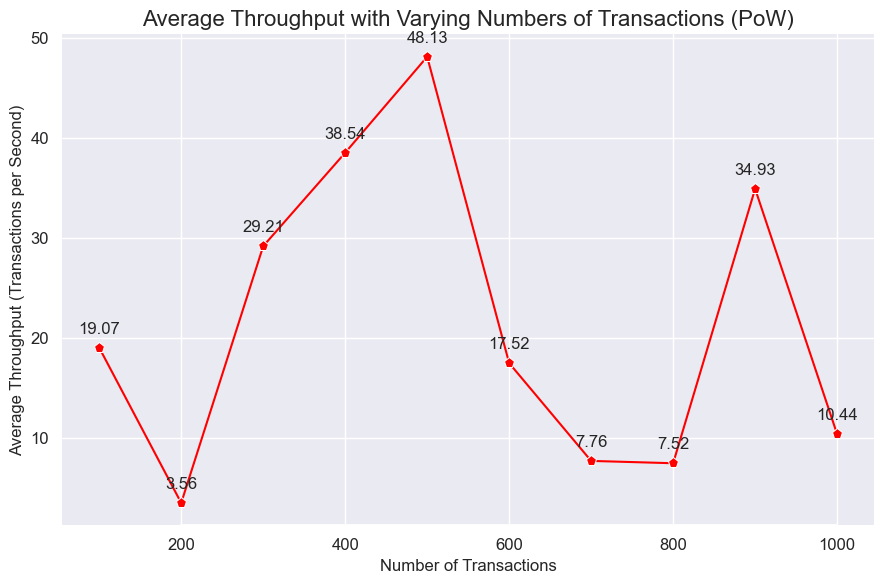

In [70]:
visualize_pow_throughput(throughputs_pow)

In [71]:
import time  # Import the time module

def simulate_pos_throughputs():
    blockchain_pos = PoSConsensus()
    validator_addresses = ["Validator_1", "Validator_2", "Validator_3", "Validator_4", "Validator_4", "Validator_5"]
    for address in validator_addresses:
        blockchain_pos.add_validator(address)

    # Simulation for PoS
    num_transactions_pos = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    throughputs_pos = {}
    pos_latencies = {}

    for num_tx in num_transactions_pos:
        start_time = time.time()
        
        # Introduce a delay between each transaction
        transaction_delay = 0.00001  # Adjust the delay time as needed
        
        for _ in range(num_tx):
            blockchain_pos.add_transaction("Arafat", "Chopra", 5)
            time.sleep(transaction_delay)  # Add a delay between transactions
            
        last_block_pos = blockchain_pos.last_block()
        proof_pos = blockchain_pos.proof_of_stake(last_block_pos)
        blockchain_pos.add_transaction(sender="00", recipient="MinerAddress", amount=5)

        # Increase block time to slow down block creation
        block_creation_delay = 1  # Adjust the block creation delay time as needed
        time.sleep(block_creation_delay)  # Add a delay between block creations

        previous_hash_pos = blockchain_pos.get_previous_hash(last_block_pos)
        blockchain_pos.create_block(proof_pos, previous_hash_pos)
        end_time = time.time()
        pos_latencies[num_tx] = (end_time - start_time) / num_tx

        # Calculate throughput
        time_taken = end_time - start_time
        throughput_pos = num_tx / time_taken
        throughputs_pos[num_tx] = throughput_pos

        # Calculate and store latency
        pos_latencies[num_tx] = time_taken / num_tx
        #print(throughputs_pos)

    #visualize_pos_throughput(throughputs_pos)
    return throughputs_pos


In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_pos_throughput(throughputs):
    # Set a seaborn style
    sns.set(style="darkgrid")

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(9, 6))

    # Plot the data as a line plot
    sns.lineplot(x=list(throughputs.keys()), y=list(throughputs.values()), marker='p', ax=ax, markersize=8, color='red')

    # Add labels and title
    ax.set_xlabel('Number of Transactions', fontsize=12)
    ax.set_ylabel('Average Throughput (Transactions per Second)', fontsize=12)
    ax.set_title('Average Throughput with Varying Numbers of Transactions (Proof of Stake)', fontsize=16)

    # Add grid lines
    ax.grid(True)

    # Customize the plot aesthetics
    sns.despine(trim=True, left=True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Annotate data points with values
    for x, y in zip(list(throughputs.keys()), list(throughputs.values())):
        ax.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

    # Save the figure and show
    plt.tight_layout()
    plt.savefig('Average_Throughput_Pos.png', dpi=300)
    plt.show()

# Example usage:
# visualize_pos_throughput(your_throughput_data)


In [73]:
throughputs_pos = simulate_pos_throughputs()
print("throughputs PoS :",throughputs_pos)


throughputs PoS : {100: 38.53807398755533, 200: 52.34721359590993, 300: 63.50946586868515, 400: 73.13086612428967, 500: 77.43508395448299, 600: 80.9546552646098, 700: 85.69245241331484, 800: 89.0737271910789, 900: 87.78018250564469, 1000: 71.88827486438456}


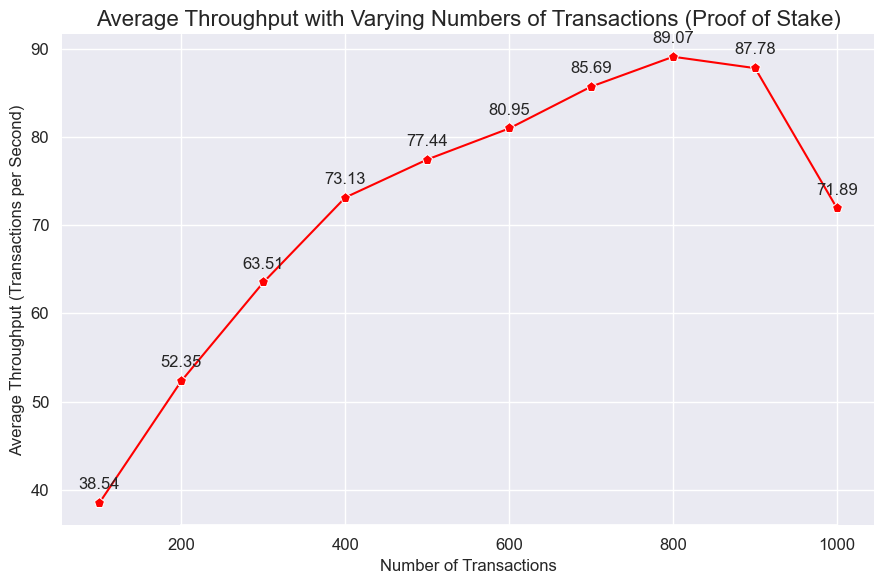

In [74]:
visualize_pos_throughput(throughputs_pos)

In [75]:
import time
import random  # Add random for simulating realistic variations in time

def simulate_dpos_throughputs():
    blockchain_dpos = DPoSConsensus()
    delegate_addresses = ["Delegate1", "Delegate2", "Delegate3"]  
    for address in delegate_addresses:
        blockchain_dpos.add_delegate(address)

    num_transactions_dpos = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    throughputs_dpos = {}

    for num_tx in num_transactions_dpos:
        start_time = time.time()
        for _ in range(num_tx):
            # Simulate a transaction with a random delay (between 0.01 and 0.1 seconds)
            time.sleep(random.uniform(0.00001, 0.00005))
            blockchain_dpos.add_transaction("Arafat", "Chopra", 1)

        # Simulate block creation with a random delay (between 0.1 and 0.5 seconds)
        time.sleep(random.uniform(0.1, 0.5))
        last_block_dpos = blockchain_dpos.last_block()
        proof_dpos = blockchain_dpos.delegated_proof_of_stake(last_block_dpos)
        blockchain_dpos.add_transaction(sender="0", recipient="MinerAddress", amount=1)
        previous_hash_dpos = blockchain_dpos.get_previous_hash(last_block_dpos)
        blockchain_dpos.create_block(proof_dpos, previous_hash_dpos)
        end_time = time.time()
        
        time_taken = end_time - start_time
        throughput_dpos = num_tx / time_taken
        throughputs_dpos[num_tx] = throughput_dpos
        print(throughputs_dpos)
    #visualize_dpos_throughput(throughputs_dpos)
    return throughputs_dpos



In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_dpos_throughput(throughputs):
    # Set a seaborn style
    sns.set(style="darkgrid")

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(9, 6))

    # Plot the data as a line plot
    sns.lineplot(x=list(throughputs.keys()), y=list(throughputs.values()), marker='p', ax=ax, markersize=8, color='red')

    # Add labels and title
    ax.set_xlabel('Number of Transactions', fontsize=12)
    ax.set_ylabel('Average Throughput (Transactions per Second)', fontsize=12)
    ax.set_title('Average Throughput with Varying Numbers of Transactions (DPoS)', fontsize=16)

    # Add grid lines
    ax.grid(True)

    # Customize the plot aesthetics
    sns.despine(trim=True, left=True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Annotate data points with values
    for x, y in zip(list(throughputs.keys()), list(throughputs.values())):
        ax.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

    # Save the figure and show
    plt.tight_layout()
    plt.savefig('Average_Throughput_DPoS.png', dpi=300)
    plt.show()

# Example usage:
# visualize_pos_throughput(your_throughput_data)


In [77]:
throughputs_dpos = simulate_dpos_throughputs()

{100: 58.04458453109076}
{100: 58.04458453109076, 200: 59.01096822396824}
{100: 58.04458453109076, 200: 59.01096822396824, 300: 75.25149743034942}
{100: 58.04458453109076, 200: 59.01096822396824, 300: 75.25149743034942, 400: 99.07896782033093}
{100: 58.04458453109076, 200: 59.01096822396824, 300: 75.25149743034942, 400: 99.07896782033093, 500: 97.32196059140733}
{100: 58.04458453109076, 200: 59.01096822396824, 300: 75.25149743034942, 400: 99.07896782033093, 500: 97.32196059140733, 600: 98.03355376299204}
{100: 58.04458453109076, 200: 59.01096822396824, 300: 75.25149743034942, 400: 99.07896782033093, 500: 97.32196059140733, 600: 98.03355376299204, 700: 89.68964859192906}
{100: 58.04458453109076, 200: 59.01096822396824, 300: 75.25149743034942, 400: 99.07896782033093, 500: 97.32196059140733, 600: 98.03355376299204, 700: 89.68964859192906, 800: 94.3004283484336}
{100: 58.04458453109076, 200: 59.01096822396824, 300: 75.25149743034942, 400: 99.07896782033093, 500: 97.32196059140733, 600: 98.

In [78]:
print("throughputs_dpos: ", throughputs_dpos)

throughputs_dpos:  {100: 58.04458453109076, 200: 59.01096822396824, 300: 75.25149743034942, 400: 99.07896782033093, 500: 97.32196059140733, 600: 98.03355376299204, 700: 89.68964859192906, 800: 94.3004283484336, 900: 98.63577581634225, 1000: 84.98871853494931}


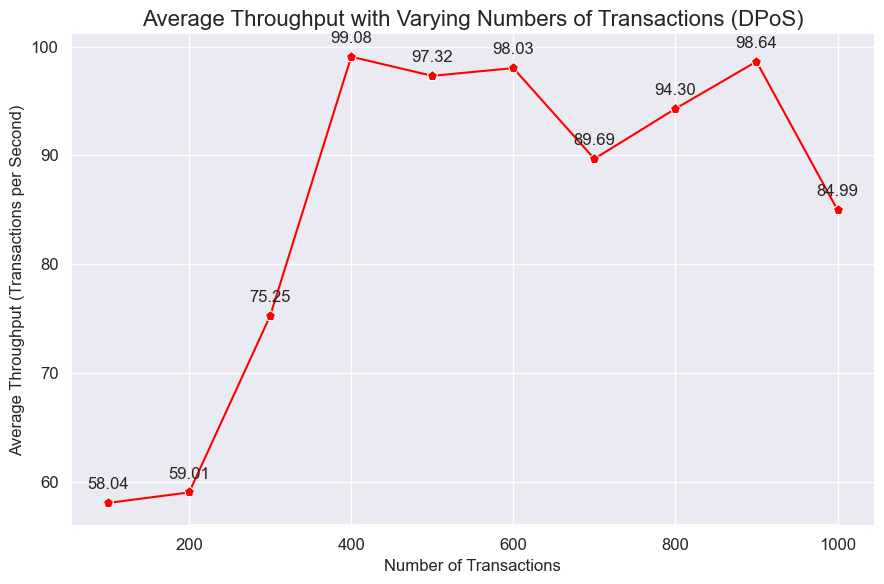

In [79]:
visualize_dpos_throughput(throughputs_dpos)

In [80]:
def simulate_raft_throughputs():
    num_nodes = 5
    num_transactions_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000] # Reduced number of transactions
    initial_leader_node_id = 0  # Manually specify the initial leader node ID
    max_duration_seconds = 5  # Specify the maximum duration of the simulation in seconds
    
    nodes = [RaftNode(node_id, num_nodes) for node_id in range(num_nodes)]

    throughputs = {}

    for num_tx in num_transactions_list:
        start_time = time.time()
        print(f"Starting transaction loop for {num_tx} transactions...")

        # Reset all nodes to "follower" state
        for node in nodes:
            node.state = "follower"
        
        # Find the initial leader node
        initial_leader = nodes[initial_leader_node_id]
        initial_leader.become_leader()

        # Track how many transactions have been processed by all nodes
        transactions_processed = 0

        while transactions_processed < num_tx:
            leader_node = find_initial_leader(nodes)

            if leader_node is not None:
                leader_node.process_transaction()
                transactions_processed += 1

        end_time = time.time()
        print(f"Transaction loop for {num_tx} transactions completed in {end_time - start_time:.2f} seconds.")

        time_taken = end_time - start_time
        if time_taken > 0:
            throughput = num_tx / time_taken
            throughputs[num_tx] = throughput
            print(throughputs)
    #visualize_raft_throughput(throughputs)
    return throughputs


In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_raft_throughput(throughputs):
    # Set a seaborn style
    sns.set(style="darkgrid")

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(9, 6))

    # Plot the data as a line plot
    sns.lineplot(x=list(throughputs.keys()), y=list(throughputs.values()), marker='p', ax=ax, markersize=8, color='red')

    # Add labels and title
    ax.set_xlabel('Number of Transactions', fontsize=12)
    ax.set_ylabel('Average Throughput (Transactions per Second)', fontsize=12)
    ax.set_title('Average Throughput with Varying Numbers of Transactions (Raft)', fontsize=16)

    # Add grid lines
    ax.grid(True)

    # Customize the plot aesthetics
    sns.despine(trim=True, left=True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Annotate data points with values
    for x, y in zip(list(throughputs.keys()), list(throughputs.values())):
        ax.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

    # Save the figure and show
    plt.tight_layout()
    plt.savefig('Average_Throughput_raft.png', dpi=300)
    plt.show()

# Example usage:
# visualize_pos_throughput(your_throughput_data)


In [82]:
raft_throughputs = simulate_raft_throughputs()
print("raft_throughputs : ", raft_throughputs)

Starting transaction loop for 100 transactions...
Transaction loop for 100 transactions completed in 1.35 seconds.
{100: 73.96046699281679}
Starting transaction loop for 200 transactions...
Transaction loop for 200 transactions completed in 3.09 seconds.
{100: 73.96046699281679, 200: 64.77672568272794}
Starting transaction loop for 300 transactions...
Transaction loop for 300 transactions completed in 4.64 seconds.
{100: 73.96046699281679, 200: 64.77672568272794, 300: 64.65332718532395}
Starting transaction loop for 400 transactions...
Transaction loop for 400 transactions completed in 6.13 seconds.
{100: 73.96046699281679, 200: 64.77672568272794, 300: 64.65332718532395, 400: 65.20538070190432}
Starting transaction loop for 500 transactions...
Transaction loop for 500 transactions completed in 7.65 seconds.
{100: 73.96046699281679, 200: 64.77672568272794, 300: 64.65332718532395, 400: 65.20538070190432, 500: 65.33303476088597}
Starting transaction loop for 600 transactions...
Transactio

In [83]:
print("raft_throughputs : ", raft_throughputs)

raft_throughputs :  {100: 73.96046699281679, 200: 64.77672568272794, 300: 64.65332718532395, 400: 65.20538070190432, 500: 65.33303476088597, 600: 65.89991684548619, 700: 75.0652196562125, 800: 60.948365352791654, 900: 60.44056837619879, 1000: 65.30928697393087}


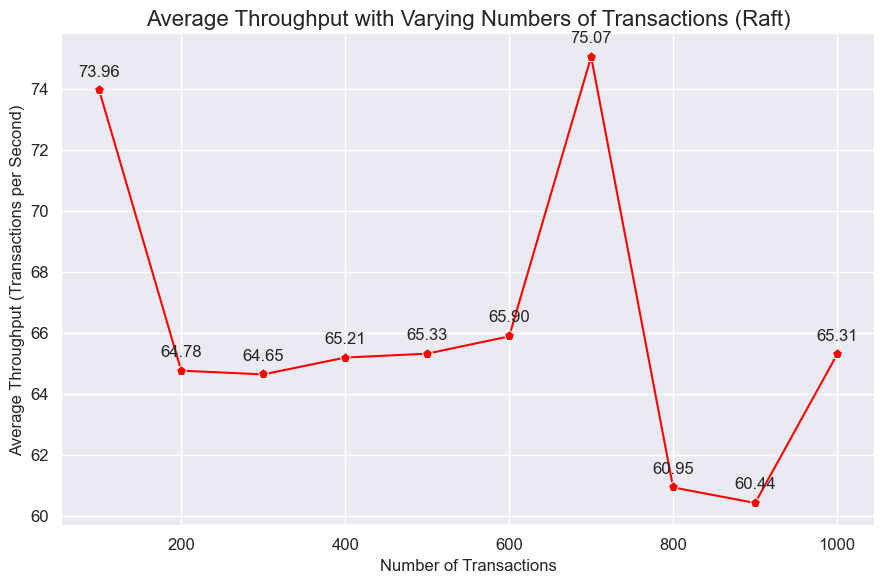

In [84]:
visualize_raft_throughput(raft_throughputs)

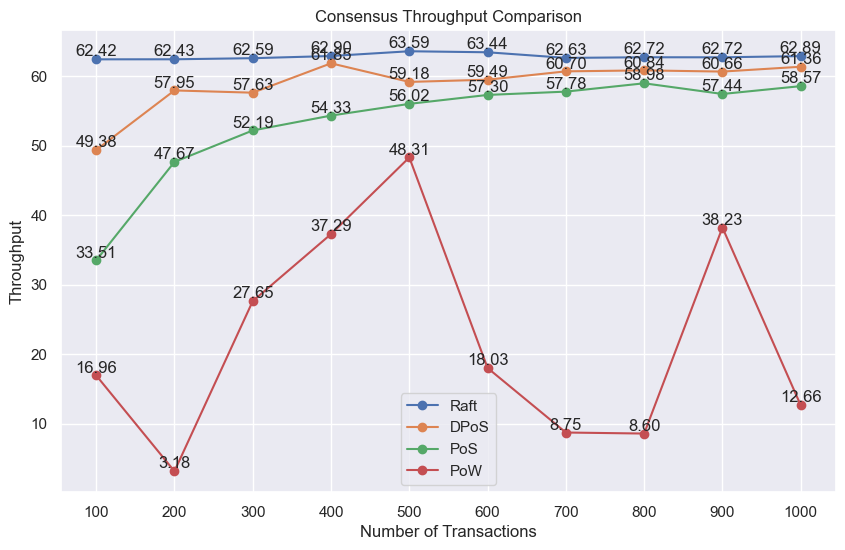

In [85]:
import matplotlib.pyplot as plt

# Throughput data
raft_throughputs = {
    100: 62.424369517148115, 200: 62.43240700716507, 300: 62.58895037402171,
    400: 62.90128153946702, 500: 63.58697766378971, 600: 63.4389431319818,
    700: 62.631345529184564, 800: 62.72215313104176, 900: 62.71578753771484,
    1000: 62.88832110578503
}

throughputs_dpos = {
    100: 49.37953937432629, 200: 57.95205057186542, 300: 57.62630888613698,
    400: 61.851540003149125, 500: 59.176290746780005, 600: 59.4941632143924,
    700: 60.69523525461582, 800: 60.835073098416714, 900: 60.663356002475275,
    1000: 61.35689915052454
}

throughputs_pos = {
    100: 33.50740368877473, 200: 47.67022957052793, 300: 52.19339257640757,
    400: 54.33477035620927, 500: 56.019078122091315, 600: 57.303775435758574,
    700: 57.78015326118836, 800: 58.97753562040681, 900: 57.441280073780504,
    1000: 58.56965642812293
}

throughputs_pow = {
    100: 16.960422483668587, 200: 3.1761860800875583, 300: 27.647821463652903,
    400: 37.288830019955505, 500: 48.31471393415387, 600: 18.02718133428264,
    700: 8.747533338935781, 800: 8.597846547746798, 900: 38.22638925982949,
    1000: 12.66473959172757
}

# Extract x and y values
x = list(raft_throughputs.keys())
raft_y = list(raft_throughputs.values())
dpos_y = list(throughputs_dpos.values())
pos_y = list(throughputs_pos.values())
pow_y = list(throughputs_pow.values())

# Create the line plot
plt.figure(figsize=(10, 6))
plt.plot(x, raft_y, marker='o', label='Raft')
plt.plot(x, dpos_y, marker='o', label='DPoS')
plt.plot(x, pos_y, marker='o', label='PoS')
plt.plot(x, pow_y, marker='o', label='PoW')

# Set labels and title
plt.xlabel('Number of Transactions')
plt.ylabel('Throughput')
plt.title('Consensus Throughput Comparison')
plt.xticks(x)

# Add a legend
plt.legend()

# Display values on data points
for i in range(len(x)):
    plt.text(x[i], raft_y[i], f'{raft_y[i]:.2f}', ha='center', va='bottom')
    plt.text(x[i], dpos_y[i], f'{dpos_y[i]:.2f}', ha='center', va='bottom')
    plt.text(x[i], pos_y[i], f'{pos_y[i]:.2f}', ha='center', va='bottom')
    plt.text(x[i], pow_y[i], f'{pow_y[i]:.2f}', ha='center', va='bottom')

# Show the plot
plt.grid(True)
plt.show()


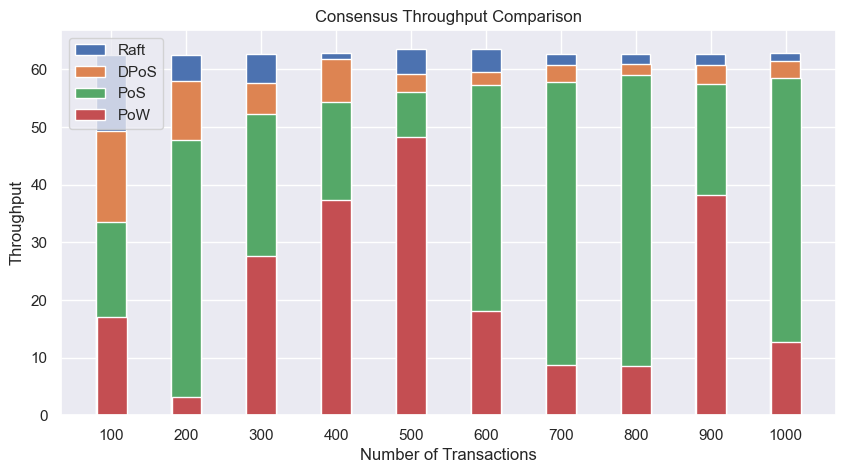

In [86]:
import matplotlib.pyplot as plt

# Throughput data
raft_throughputs = {
    100: 62.424369517148115, 200: 62.43240700716507, 300: 62.58895037402171,
    400: 62.90128153946702, 500: 63.58697766378971, 600: 63.4389431319818,
    700: 62.631345529184564, 800: 62.72215313104176, 900: 62.71578753771484,
    1000: 62.88832110578503
}

throughputs_dpos = {
    100: 49.37953937432629, 200: 57.95205057186542, 300: 57.62630888613698,
    400: 61.851540003149125, 500: 59.176290746780005, 600: 59.4941632143924,
    700: 60.69523525461582, 800: 60.835073098416714, 900: 60.663356002475275,
    1000: 61.35689915052454
}

throughputs_pos = {
    100: 33.50740368877473, 200: 47.67022957052793, 300: 52.19339257640757,
    400: 54.33477035620927, 500: 56.019078122091315, 600: 57.303775435758574,
    700: 57.78015326118836, 800: 58.97753562040681, 900: 57.441280073780504,
    1000: 58.56965642812293
}

throughputs_pow = {
    100: 16.960422483668587, 200: 3.1761860800875583, 300: 27.647821463652903,
    400: 37.288830019955505, 500: 48.31471393415387, 600: 18.02718133428264,
    700: 8.747533338935781, 800: 8.597846547746798, 900: 38.22638925982949,
    1000: 12.66473959172757
}

# Extract x and y values
x = list(raft_throughputs.keys())
raft_y = list(raft_throughputs.values())
dpos_y = list(throughputs_dpos.values())
pos_y = list(throughputs_pos.values())
pow_y = list(throughputs_pow.values())

# Create the bar plot
plt.figure(figsize=(10, 5))
plt.bar(x, raft_y, width= 40, label='Raft')
plt.bar([num + 0.2 for num in x], dpos_y, width=40, label='DPoS')
plt.bar([num + 0.4 for num in x], pos_y, width=40, label='PoS')
plt.bar([num + 0.6 for num in x], pow_y, width=40, label='PoW')

# Set labels and title
plt.xlabel('Number of Transactions')
plt.ylabel('Throughput')
plt.title('Consensus Throughput Comparison')
plt.xticks([num + 0.3 for num in x], x)

# Add a legend
plt.legend()

# Display values on data points
#for i in range(len(x)):
   # plt.text(x[i], raft_y[i], f'{raft_y[i]:.2f}', ha='center', va='bottom')
   # plt.text(x[i] + 0.2, dpos_y[i], f'{dpos_y[i]:.2f}', ha='center', va='bottom')
   # plt.text(x[i] + 0.4, pos_y[i], f'{pos_y[i]:.2f}', ha='center', va='bottom')
    #plt.text(x[i] + 0.6, pow_y[i], f'{pow_y[i]:.2f}', ha='center', va='bottom')

# Show the plot
plt.grid(True)
plt.show()


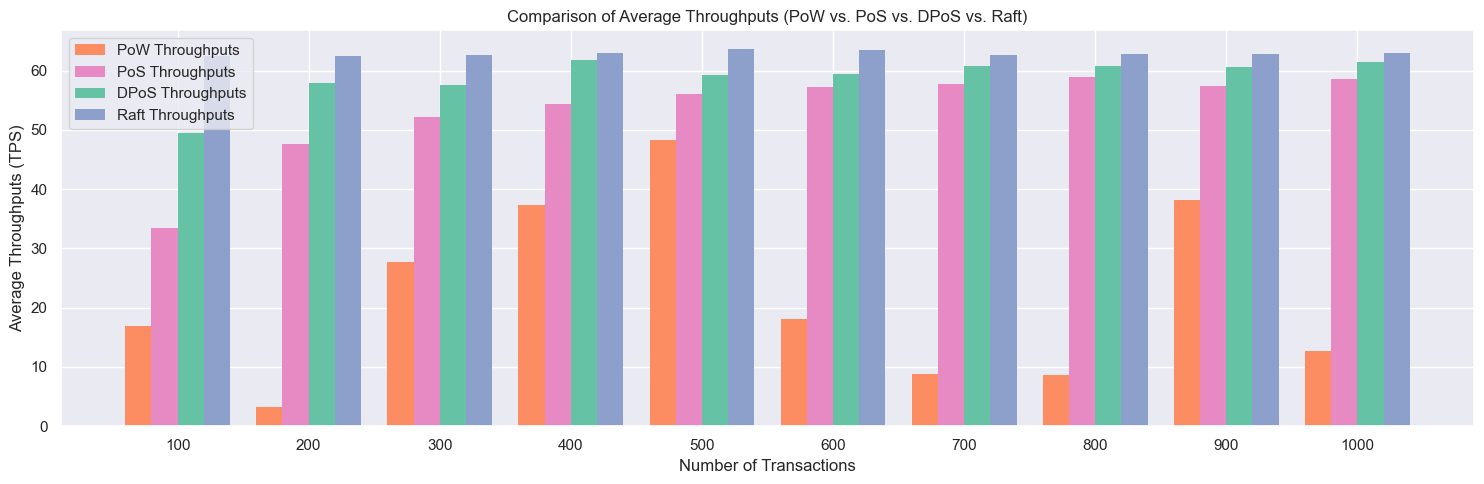

In [87]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Define a color palette
colors = sns.color_palette('Set2', n_colors=4)
# Data
num_transactions = list(throughputs_pow.keys())
pow_throughputs_values = list(throughputs_pow.values())
pos_throughputs_values = list(throughputs_pos.values())
dpos_throughputs_values = list(throughputs_dpos.values())
raft_throughputs_values = list(raft_throughputs.values())


width = 0.2
fig, ax = plt.subplots(figsize=(15, 5))

# Positions for the bars
x = np.arange(len(num_transactions))

# Create grouped bars
#bar1 = ax.bar(x - width, pow_throughputs_values, width, label='PoW Throughputs', color='slateblue', edgecolor='none', linewidth=0.7)
#bar2 = ax.bar(x, pos_throughputs_values, width, label='PoS Throughputs', color='salmon', edgecolor='none', linewidth=0.7)
#bar3 = ax.bar(x + width, dpos_throughputs_values, width, label='DPoS Throughputs', color='lawngreen', edgecolor='none', linewidth=0.7)
#bar4 = ax.bar(x + (width*2), raft_throughputs_values, width, label='Raft Throughputs', color='mediumblue', edgecolor='none', linewidth=0.7)

# Create grouped bars with colors from the palette
bar1 = ax.bar(x - 1.5 * width, pow_throughputs_values, width, label='PoW Throughputs', color=colors[1], edgecolor='none', linewidth=0.7)
bar2 = ax.bar(x - 0.5 * width, pos_throughputs_values, width, label='PoS Throughputs', color=colors[3], edgecolor='none', linewidth=0.7)
bar3 = ax.bar(x + 0.5 * width, dpos_throughputs_values, width, label='DPoS Throughputs', color=colors[0], edgecolor='none', linewidth=0.7)
bar4 = ax.bar(x + 1.5 * width, raft_throughputs_values, width, label='Raft Throughputs', color=colors[2], edgecolor='none', linewidth=0.7)

# Set labels and title
ax.set_xlabel('Number of Transactions')
ax.set_ylabel('Average Throughputs (TPS)')
ax.set_title('Comparison of Average Throughputs (PoW vs. PoS vs. DPoS vs. Raft)')
ax.set_xticks(x)
ax.set_xticklabels(num_transactions)
ax.legend()
ax.grid(True)

# Display values on data points
def add_values(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

#add_values(bar1)
#add_values(bar2)
#add_values(bar3)
#add_values(bar4)

plt.tight_layout()
plt.savefig('Comparision of Average Throughput_pow_pos_dpos_raft.png', dpi=300)
plt.show()


pow_latencies: {100: 0.0532816219329834, 500: 0.010878747940063476, 1000: 0.00550137996673584, 1500: 0.003948385079701741, 2000: 0.0028084115982055665}
pos_latencies: {100: 0.0009437727928161621, 500: 0.0004252042770385742, 1000: 0.00021535181999206542, 1500: 6.470171610514323e-05, 2000: 0.00010953271389007568}
dpos_latencies: {100: 0.001547701358795166, 500: 9.485626220703125e-05, 1000: 4.539036750793457e-05, 1500: 0.00016690699259440105, 2000: 8.052337169647217e-05}
raft_latencies: {100: 0.25254881381988525, 500: 0.050655524253845216, 1000: 0.02533275771141052, 1500: 0.01677426592508952, 2000: 0.012697453260421753}


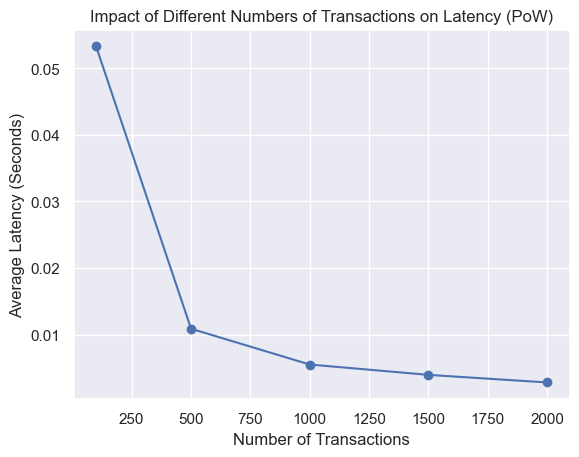

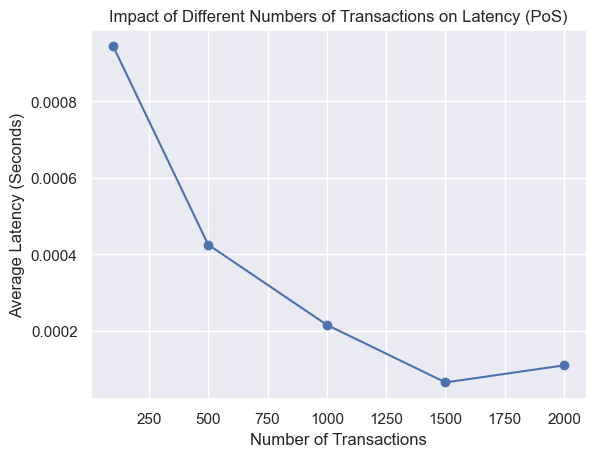

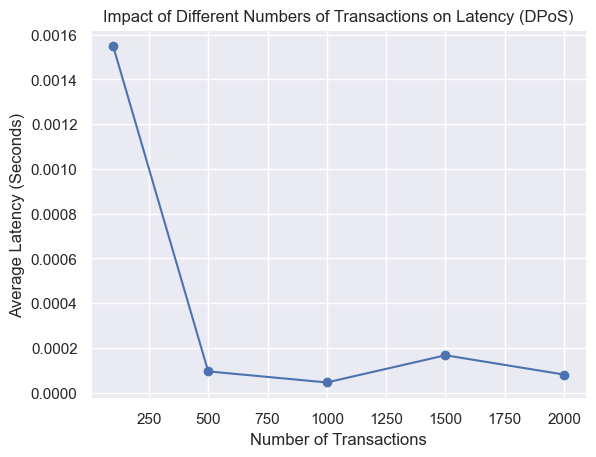

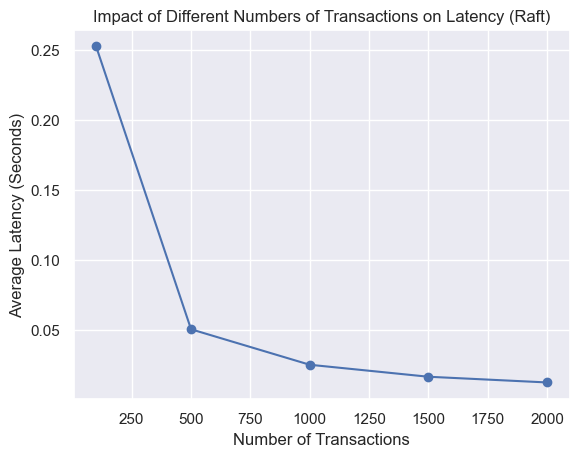

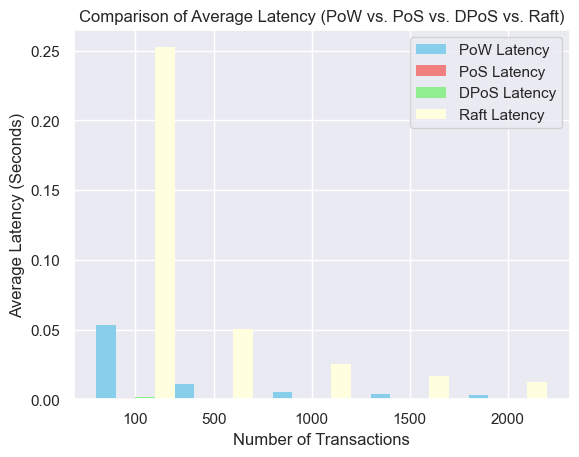

In [88]:
simulate_latency_impact()

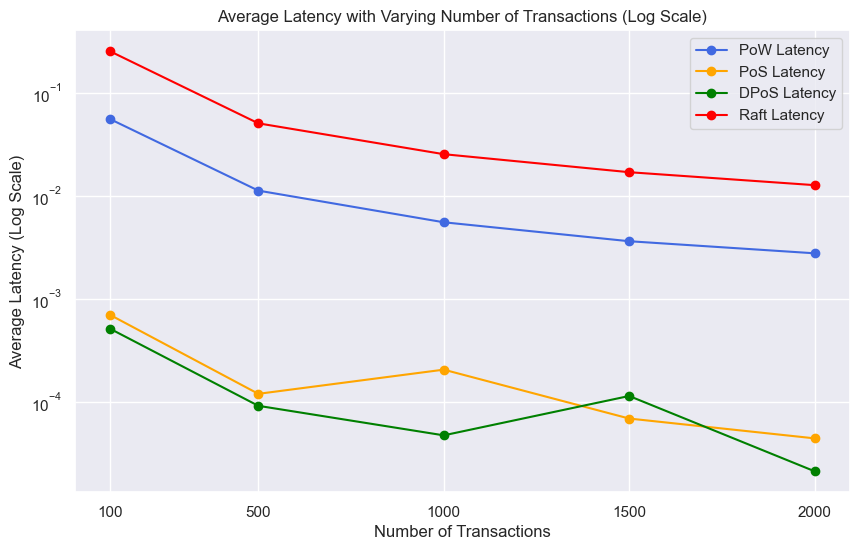

In [89]:
import matplotlib.pyplot as plt
import numpy as np

# Data (replace with your actual data)
num_transactions = [100, 500, 1000, 1500, 2000]
pow_latencies = {100: 0.05560929536819458, 500: 0.011211042404174804, 1000: 0.005520173788070679, 1500: 0.003613100369771322, 2000: 0.0027570225000381468}
pos_latencies = {100: 0.0006953501701354981, 500: 0.00011875152587890625, 1000: 0.00020401740074157715, 1500: 6.831471125284831e-05, 2000: 4.3844223022460934e-05}
dpos_latencies = {100: 0.0005100798606872558, 500: 9.080696105957032e-05, 1000: 4.690051078796387e-05, 1500: 0.00011315504709879558, 2000: 2.0999431610107423e-05}
raft_latencies = {100: 0.25356934070587156, 500: 0.050534528732299806, 1000: 0.02533510112762451, 1500: 0.01693139664332072, 2000: 0.012669727802276612}

# Plot data on a logarithmic scale
plt.figure(figsize=(10, 6))
plt.semilogy(num_transactions, list(pow_latencies.values()), marker='o', label='PoW Latency', color='royalblue')
plt.semilogy(num_transactions, list(pos_latencies.values()), marker='o', label='PoS Latency', color='orange')
plt.semilogy(num_transactions, list(dpos_latencies.values()), marker='o', label='DPoS Latency', color='green')
plt.semilogy(num_transactions, list(raft_latencies.values()), marker='o', label='Raft Latency', color='red')

# Set labels and title
plt.xlabel('Number of Transactions')
plt.ylabel('Average Latency (Log Scale)')
plt.title('Average Latency with Varying Number of Transactions (Log Scale)')
plt.xticks(num_transactions)

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


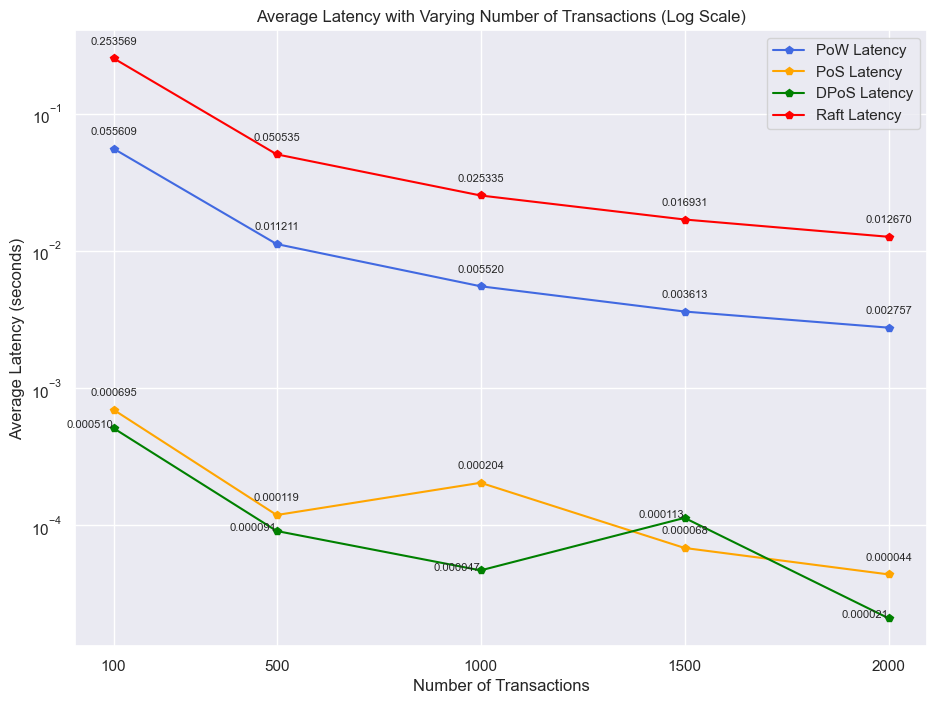

In [90]:
import matplotlib.pyplot as plt
import numpy as np

# Data (replace with your actual data)
num_transactions = [100, 500, 1000, 1500, 2000]
pow_latencies = {100: 0.05560929536819458, 500: 0.011211042404174804, 1000: 0.005520173788070679, 1500: 0.003613100369771322, 2000: 0.0027570225000381468}
pos_latencies = {100: 0.0006953501701354981, 500: 0.00011875152587890625, 1000: 0.00020401740074157715, 1500: 6.831471125284831e-05, 2000: 4.3844223022460934e-05}
dpos_latencies = {100: 0.0005100798606872558, 500: 9.080696105957032e-05, 1000: 4.690051078796387e-05, 1500: 0.00011315504709879558, 2000: 2.0999431610107423e-05}
raft_latencies = {100: 0.25356934070587156, 500: 0.050534528732299806, 1000: 0.02533510112762451, 1500: 0.01693139664332072, 2000: 0.012669727802276612}

# Create a figure and axis with a logarithmic y-scale
fig, ax = plt.subplots(figsize=(11, 8))
ax.set_yscale('log')
#fig, ax = plt.subplots()
#ax.set_yscale('log')

# Plot data with markers
ax.plot(num_transactions, list(pow_latencies.values()), marker='p', label='PoW Latency', color='royalblue')
ax.plot(num_transactions, list(pos_latencies.values()), marker='p', label='PoS Latency', color='orange')
ax.plot(num_transactions, list(dpos_latencies.values()), marker='p', label='DPoS Latency', color='green')
ax.plot(num_transactions, list(raft_latencies.values()), marker='p', label='Raft Latency', color='red')

# Add data labels with up to 6 decimal places
for tx, val in pow_latencies.items():
    ax.annotate(f'{val:.6f}', (tx, val), fontsize=8, textcoords="offset points", xytext=(0, 10), ha='center')
for tx, val in pos_latencies.items():
    ax.annotate(f'{val:.6f}', (tx, val), fontsize=8, textcoords="offset points", xytext=(0, 10), ha='center')
for tx, val in dpos_latencies.items():
    ax.annotate(f'{val:.6f}', (tx, val), fontsize=8, textcoords="offset points", xytext=(0, 0), ha='right')
for tx, val in raft_latencies.items():
    ax.annotate(f'{val:.6f}', (tx, val), fontsize=8, textcoords="offset points", xytext=(0, 10), ha='center')

# Set labels and title
ax.set_xlabel('Number of Transactions')
ax.set_ylabel('Average Latency (seconds)')
ax.set_title('Average Latency with Varying Number of Transactions (Log Scale)')

# Set x-axis ticks
ax.set_xticks(num_transactions)

# Add a legend
ax.legend()

# Show the plot
plt.grid(True)
plt.savefig('Average Latency with Varying Number of Transactions Log Scale.png', dpi=300, bbox_inches='tight')
plt.show()


In [91]:
# Average latency with varying numbers of nodes
num_nodes = [5, 10, 15, 20, 25, 30, 35, 40]
# Simulate latency for PoW and PoS with varying numbers of nodes
pow_latencies = simulate_latency_with_nodes_pow(num_nodes)
pos_latencies = simulate_latency_with_nodes_pos(num_nodes)
dpos_latencies = simulate_latency_with_nodes_dpos(num_nodes)
raft_latencies = simulate_latency_with_nodes_raft(num_nodes)
for num_n, latency in raft_latencies.items():
    print(f"Nodes: {num_n}, Average Latency: {latency:.4f} seconds")
# Visualize the data
#visualize_latency_with_nodes(pow_latencies, pos_latencies,dpos_latencies)

Simulating Raft with 5 nodes...
Simulation with 5 nodes completed in 25.25 seconds.
Simulating Raft with 10 nodes...
Simulation with 10 nodes completed in 50.60 seconds.
Simulating Raft with 15 nodes...
Simulation with 15 nodes completed in 75.75 seconds.
Simulating Raft with 20 nodes...
Simulation with 20 nodes completed in 100.91 seconds.
Simulating Raft with 25 nodes...
Simulation with 25 nodes completed in 126.01 seconds.
Simulating Raft with 30 nodes...
Simulation with 30 nodes completed in 151.57 seconds.
Simulating Raft with 35 nodes...
Simulation with 35 nodes completed in 176.72 seconds.
Simulating Raft with 40 nodes...
Simulation with 40 nodes completed in 201.86 seconds.
Nodes: 5, Average Latency: 0.0252 seconds
Nodes: 10, Average Latency: 0.0506 seconds
Nodes: 15, Average Latency: 0.0757 seconds
Nodes: 20, Average Latency: 0.1009 seconds
Nodes: 25, Average Latency: 0.1260 seconds
Nodes: 30, Average Latency: 0.1516 seconds
Nodes: 35, Average Latency: 0.1767 seconds
Nodes: 40

In [92]:
print("pow_latencies:",pow_latencies)
print("pos_latencies:",pos_latencies)
print("dpos_latencies:",dpos_latencies)
print("raft_latencies:",raft_latencies)

pow_latencies: {5: 0.006327616453170776, 10: 0.005535756587982178, 15: 0.0054059290885925294, 20: 0.006354672908782959, 25: 0.005812376260757446, 30: 0.005998341083526612, 35: 0.006360718965530396, 40: 0.006296689987182617}
pos_latencies: {5: 0.00010120129585266113, 10: 0.00023200225830078124, 15: 0.0002334613800048828, 20: 5.8733463287353516e-05, 25: 0.0002539606094360352, 30: 6.0000181198120115e-05, 35: 0.00010671758651733398, 40: 5.925559997558594e-05}
dpos_latencies: {5: 0.00018211793899536132, 10: 0.00017996740341186523, 15: 4.51960563659668e-05, 20: 4.7362089157104495e-05, 25: 4.798126220703125e-05, 30: 4.872775077819824e-05, 35: 0.00016943717002868654, 40: 0.00017699432373046876}
raft_latencies: {5: 0.025245495319366457, 10: 0.050596468448638916, 15: 0.07574701714515686, 20: 0.10091056895256043, 25: 0.12601127815246582, 30: 0.1515744092464447, 35: 0.1767181167602539, 40: 0.20186246156692506}


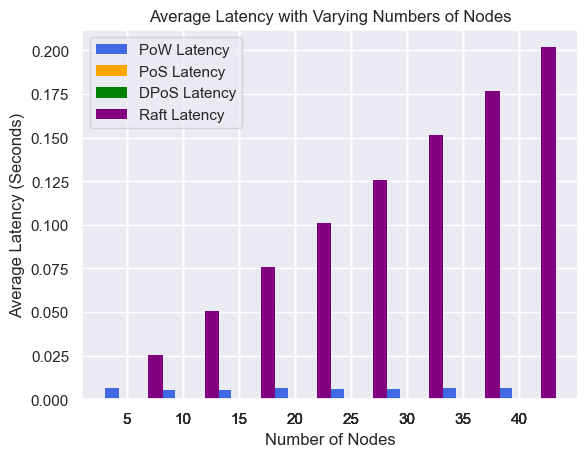

In [93]:
num_nodes = [5, 10, 15, 20, 25, 30, 35, 40]
visualize_latency_with_nodes(pow_latencies, pos_latencies, dpos_latencies, raft_latencies, num_nodes)

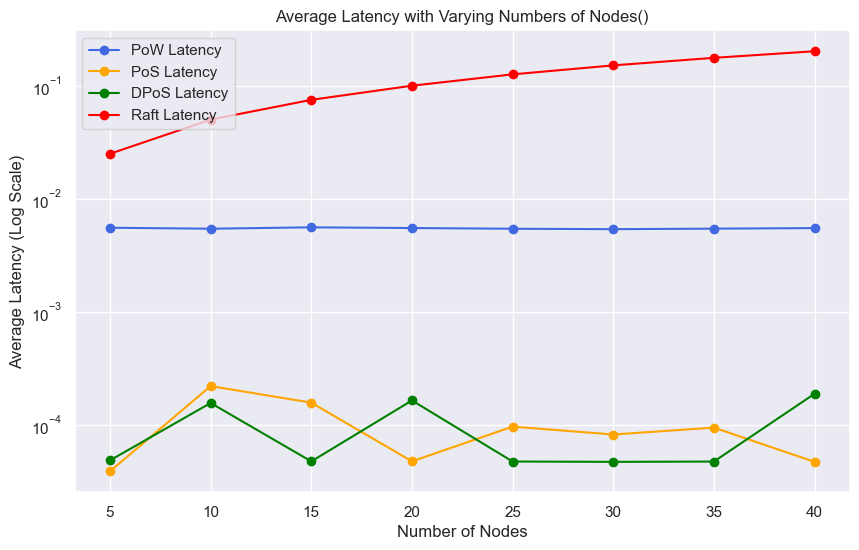

In [94]:
import matplotlib.pyplot as plt
import numpy as np

# Data (replace with your actual data)
num_nodes = [5, 10, 15, 20, 25, 30, 35, 40]
pow_latencies = {5: 0.005546874523162841, 10: 0.005437691450119018, 15: 0.0055935182571411135, 20: 0.005513352155685425, 25: 0.00543338418006897, 30: 0.005386836051940918, 35: 0.005444554805755615, 40: 0.005507029056549072}
pos_latencies = {5: 3.8748741149902344e-05, 10: 0.0002198927402496338, 15: 0.00015687227249145508, 20: 4.741668701171875e-05, 25: 9.624767303466797e-05, 30: 8.193683624267578e-05, 35: 9.429550170898438e-05, 40: 4.693531990051269e-05}
dpos_latencies = {5: 4.838132858276367e-05, 10: 0.00015578937530517578, 15: 4.736018180847168e-05, 20: 0.000164034366607666, 25: 4.726099967956543e-05, 30: 4.6929121017456057e-05, 35: 4.7220230102539065e-05, 40: 0.00018793201446533204}
raft_latencies = {5: 0.02505048894882202, 10: 0.05028015375137329, 15: 0.07521603417396545, 20: 0.10030747056007386, 25: 0.12645335531234742, 30: 0.15181209754943847, 35: 0.17708705163002014, 40: 0.20250406694412232}

# Plot data on a logarithmic scale
plt.figure(figsize=(10, 6))
plt.semilogy(num_nodes, list(pow_latencies.values()), marker='o', label='PoW Latency', color='royalblue')
plt.semilogy(num_nodes, list(pos_latencies.values()), marker='o', label='PoS Latency', color='orange')
plt.semilogy(num_nodes, list(dpos_latencies.values()), marker='o', label='DPoS Latency', color='green')
plt.semilogy(num_nodes, list(raft_latencies.values()), marker='o', label='Raft Latency', color='red')

# Set labels and title
plt.xlabel('Number of Nodes')
plt.ylabel('Average Latency (Log Scale)')
plt.title('Average Latency with Varying Numbers of Nodes()')
plt.xticks(num_nodes)

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


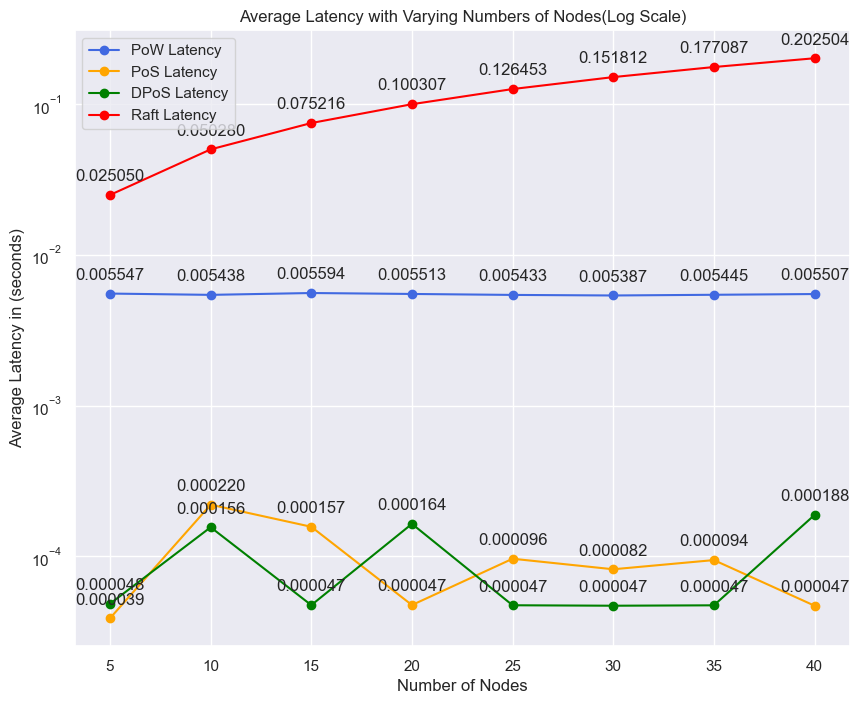

In [95]:
import matplotlib.pyplot as plt
import numpy as np

# Data (replace with your actual data)
num_nodes = [5, 10, 15, 20, 25, 30, 35, 40]
pow_latencies = {5: 0.005546874523162841, 10: 0.005437691450119018, 15: 0.0055935182571411135, 20: 0.005513352155685425, 25: 0.00543338418006897, 30: 0.005386836051940918, 35: 0.005444554805755615, 40: 0.005507029056549072}
pos_latencies = {5: 3.8748741149902344e-05, 10: 0.0002198927402496338, 15: 0.00015687227249145508, 20: 4.741668701171875e-05, 25: 9.624767303466797e-05, 30: 8.193683624267578e-05, 35: 9.429550170898438e-05, 40: 4.693531990051269e-05}
dpos_latencies = {5: 4.838132858276367e-05, 10: 0.00015578937530517578, 15: 4.736018180847168e-05, 20: 0.000164034366607666, 25: 4.726099967956543e-05, 30: 4.6929121017456057e-05, 35: 4.7220230102539065e-05, 40: 0.00018793201446533204}
raft_latencies = {5: 0.02505048894882202, 10: 0.05028015375137329, 15: 0.07521603417396545, 20: 0.10030747056007386, 25: 0.12645335531234742, 30: 0.15181209754943847, 35: 0.17708705163002014, 40: 0.20250406694412232}

# Create a figure and axis with a logarithmic y-scale and set the figure size
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_yscale('log')

# Plot data with markers
plt.semilogy(num_nodes, list(pow_latencies.values()), marker='o', label='PoW Latency', color='royalblue')
plt.semilogy(num_nodes, list(pos_latencies.values()), marker='o', label='PoS Latency', color='orange')
plt.semilogy(num_nodes, list(dpos_latencies.values()), marker='o', label='DPoS Latency', color='green')
plt.semilogy(num_nodes, list(raft_latencies.values()), marker='o', label='Raft Latency', color='red')

# Annotate data points with their values
for i, num in enumerate(num_nodes):
    ax.annotate(f'{pow_latencies[num]:.6f}', (num, pow_latencies[num]), textcoords="offset points", xytext=(0,10), ha='center')
    ax.annotate(f'{pos_latencies[num]:.6f}', (num, pos_latencies[num]), textcoords="offset points", xytext=(0,10), ha='center')
    ax.annotate(f'{dpos_latencies[num]:.6f}', (num, dpos_latencies[num]), textcoords="offset points", xytext=(0,10), ha='center')
    ax.annotate(f'{raft_latencies[num]:.6f}', (num, raft_latencies[num]), textcoords="offset points", xytext=(0,10), ha='center')

# Set labels and title
plt.xlabel('Number of Nodes')
plt.ylabel('Average Latency in (seconds)')
plt.title('Average Latency with Varying Numbers of Nodes(Log Scale)')
plt.xticks(num_nodes)

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.savefig('Average Latency with Varying Numbers of Nodes Log Scale.png', dpi=300, bbox_inches='tight')
plt.show()


In [96]:
# Record the end time
end_time = timeit.default_timer()

# Calculate the total execution time
total_time = end_time - start_time

# Print the total execution time
print(f"Total Execution Time: {total_time} seconds")

Total Execution Time: 1787.8101873000269 seconds
